# Pre-process

## Load library and define some functions needed

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import datetime as dt
import random
import time

import json
import os.path
import gc

from script.module.FeatureProducer import FeatureProducer 
MODEL_FILE_NAME = 'model.txt'

In [2]:
import numpy as np
import pandas as pd
import pickle
import implicit
import time
import os
import logging

from scipy.sparse import coo_matrix

LOG_FORMAT = '%(asctime)s %(levelname)s << %(message)s'
logging.basicConfig(level=logging.DEBUG, format=LOG_FORMAT, datefmt='%H:%M:%S')

In [3]:
class ImplicitProducer(object):

    __TRAIN_FILE_NAME = 'train.csv'
    __TEST_FILE_NAME = 'test_target.csv'

    def __init__(self, root='./data', factors=50, iterations=20):
        assert os.path.exists(root), '%s not exists!' % root
        self._root = os.path.expanduser(root)

        self._train_df = None
        self._test_df = None
        self._comb_df = None

        self._factors = factors
        self._iterations = iterations

    def prepare(self):
        start = time.time()
        # load train & test set
        self._train_df = pd.read_csv(os.path.join(self._root, self.__TRAIN_FILE_NAME))
        self._test_df = pd.read_csv(os.path.join(self._root, self.__TEST_FILE_NAME))

        self._train_df = self._train_df[['msno', 'song_id', 'target']]
        self._test_df = self._test_df[['msno', 'song_id', 'target']]
        self._comb_df = self._train_df.append(self._test_df)

        for column in self._train_df.columns:
            if self._train_df[column].dtype == object:
                self._train_df[column] = self._train_df[column].astype('category')

        for column in self._test_df.columns:
            if self._test_df[column].dtype == object:
                self._test_df[column] = self._test_df[column].astype('category')

        for column in self._comb_df.columns:
            if self._comb_df[column].dtype == object:
                self._comb_df[column] = self._comb_df[column].astype('category')

        logging.info("prepare in %0.2fs" % (time.time() - start))

    def compute(self, is_train):
        assert(isinstance(is_train, bool))

        """
        # generate recommendations for each user and write out to a file
        songs = dict(enumerate(df['song_id'].cat.categories))
        start = time.time()
        user_plays = train_csr_matrix.T.tocsr()

        with open('.out', "w") as o:
            for userid, username in enumerate(df['msno'].cat.categories):
                for songid, score in model.recommend(userid, user_plays, N=2):
                    o.write("%s\t%s\t%s\n" % (username, songs[songid], score))
        logging.debug("generated recommendations in %0.2fs",  time.time() - start)
        """
        if is_train:
            return self.generate_latent_factors(self._train_df, self._train_df)
        else:
            return self.generate_latent_factors(self._test_df, self._comb_df)

    def generate_latent_factors(self, df, ref_df):
        model = implicit.als.AlternatingLeastSquares(factors=self._factors, iterations=self._iterations)

        csr_matrix = coo_matrix((ref_df['target'].astype(float),
                                 (ref_df['song_id'].cat.codes, ref_df['msno'].cat.codes)))
        model.fit(csr_matrix)

        item_series = pd.DataFrame(data=ref_df['song_id'].cat.categories.tolist(), columns=['song_id'])
        user_series = pd.DataFrame(data=ref_df['msno'].cat.categories.tolist(), columns=['msno'])

        item_factors_df = pd.DataFrame(data=model.item_factors)
        user_factors_df = pd.DataFrame(data=model.user_factors)
        item_factors_df.columns = ['item_fac_' + str(i) for i in range(self._factors)]
        user_factors_df.columns = ['user_fac_' + str(i) for i in range(self._factors)]

        item_factors_df = item_factors_df.join(item_series)
        user_factors_df = user_factors_df.join(user_series)
        # print(item_factors_df)
        # print(user_factors_df)

        df = df.merge(item_factors_df, on='song_id', how='left')
        df = df.merge(user_factors_df, on='msno', how='left')
        # print(df)
        return df

    @property
    def train_df(self):
        return self._train_df

    @property
    def test_df(self):
        return self._test_df

In [4]:
def custom_cv(params, train_set, hold_out_set=None, k_fold=5, num_boost_round=20):
    x_train = train_set.data
    y_train = train_set.label
    n = x_train.shape[0]
    unit = n // k_fold

    cv_scores = []
    for k in range(k_fold):
        ##### !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        if k < k_fold - 1:
            continue
        ##### !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        x_cv_valid = None
        y_cv_valid = None
        if k == k_fold - 1:
            x_cv_valid = x_train[unit * k:]
            y_cv_valid = y_train[unit * k:]
        else:
            x_cv_valid = x_train[unit * k: unit * (k + 1)]
            y_cv_valid = y_train[unit * k: unit * (k + 1)]

        x_cv_train = None
        y_cv_train = None
        if k == 0:
            x_cv_train = x_train[unit * (k + 1):]
            y_cv_train = y_train[unit * (k + 1):]
        elif k == k_fold - 1:
            x_cv_train = x_train[:unit * k]
            y_cv_train = y_train[:unit * k]
        else:
            x_cv_train = x_train[:unit * k].append(x_train[unit * (k + 1):])
            y_cv_train = y_train[:unit * k].append(y_train[unit * (k + 1):])

        cv_train_set = lgb.Dataset(x_cv_train, y_cv_train)
        cv_valid_set = lgb.Dataset(x_cv_valid, y_cv_valid)
        watchlist = [cv_valid_set]

        # not tested yet
        if hold_out_set is not None:
            watchlist.append(hold_out_set)
        model = lgb.train(params, train_set=cv_train_set, valid_sets=watchlist,
                          num_boost_round=num_boost_round, verbose_eval=5)
        print(model.best_score)
        cv_scores.append(model.best_score['valid_1']['auc'])

    tip_txt = '[CV]'
    tip_txt += ' ' + str(cv_scores)
    mean_cv_score = np.mean(cv_scores)
    tip_txt += '{ auc score=' + str(mean_cv_score) + ' }'
    print(tip_txt)

    return mean_cv_score

In [5]:
def custom_grid_search(params, own_grid_params, train_set, valid_set, num_boost_round=20):
    keys = []
    values = [list()]
    for key, value in own_grid_params.items():
        keys.append(key)
        new_values = []
        for item in values:
            for val in value:
                new_values.append(item + [val])
        values = new_values

    watchlist = [valid_set]
    grid_best_params = None
    grid_best_score = None

    for comb in values:
        own_params = {}
        for idx in range(len(keys)):
            own_params[keys[idx]] = comb[idx]
            params[keys[idx]] = comb[idx]

        cv_score = custom_cv(params, train_set, valid_set, k_fold=4, num_boost_round=num_boost_round)

        tip_txt = '[GridSearch]'
        for idx in range(len(keys)):
            tip_txt += ' ' + str(keys[idx]) + '=' + str(comb[idx])
        tip_txt += ' { best_score: ' + str(cv_score) + ' }'
        print(tip_txt)

        if grid_best_score is None or cv_score > grid_best_score:
            grid_best_params, grid_best_score = own_params, cv_score

    tip_txt = '[GS Best Result]'
    for key, val in grid_best_params.items():
        tip_txt += ' ' + str(key) + '=' + str(val)
    tip_txt += ' { best_score: ' + str(grid_best_score) + ' }'
    print(tip_txt)
    
    return grid_best_params

## init

In [6]:
ip = ImplicitProducer(root='./data', factors=30, iterations=15) 

## load

In [7]:
ip.prepare()
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

12:13:20 INFO << prepare in 23.15s


## preprocess

In [8]:
train_cf_df = ip.compute(True)
test_cf_df = ip.compute(False)

12:13:40 DEBUG << finished iteration 0 in 0.4535791873931885
12:13:40 DEBUG << finished iteration 1 in 0.34566807746887207
12:13:40 DEBUG << finished iteration 2 in 0.3277883529663086
12:13:41 DEBUG << finished iteration 3 in 0.32582664489746094
12:13:41 DEBUG << finished iteration 4 in 0.31969523429870605
12:13:41 DEBUG << finished iteration 5 in 0.31557679176330566
12:13:42 DEBUG << finished iteration 6 in 0.31710147857666016
12:13:42 DEBUG << finished iteration 7 in 0.3175010681152344
12:13:42 DEBUG << finished iteration 8 in 0.31951308250427246
12:13:43 DEBUG << finished iteration 9 in 0.3212559223175049
12:13:43 DEBUG << finished iteration 10 in 0.3221263885498047
12:13:43 DEBUG << finished iteration 11 in 0.32187628746032715
12:13:44 DEBUG << finished iteration 12 in 0.3209712505340576
12:13:44 DEBUG << finished iteration 13 in 0.3204491138458252
12:13:44 DEBUG << finished iteration 14 in 0.3225536346435547
12:14:04 DEBUG << finished iteration 0 in 0.43987298011779785
12:14:05 DE

In [9]:
train_cf_df.drop(['msno', 'song_id', 'target'], axis=1, inplace=True)
test_cf_df.drop(['msno', 'song_id', 'target'], axis=1, inplace=True)

In [10]:
train_df = train_df.join(train_cf_df)
test_df = test_df.join(test_cf_df)

In [11]:
train_df

,msno,song_id,source_system_tab,source_screen_name,source_type,target,item_fac_0,item_fac_1,item_fac_2,item_fac_3,...,user_fac_20,user_fac_21,user_fac_22,user_fac_23,user_fac_24,user_fac_25,user_fac_26,user_fac_27,user_fac_28,user_fac_29
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,2.991370e-01,-2.044715e-01,-1.592505e-01,9.908837e-02,...,0.093982,0.002097,0.040292,0.026109,-0.060797,0.154261,0.161054,-0.037780,-0.189195,0.027857
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,2.039421e-03,8.335425e-03,-1.113013e-03,3.503679e-03,...,-0.008633,0.015745,0.035060,0.001035,0.030397,-0.023668,-0.014755,0.033238,0.057557,-0.061357
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,3.215673e-03,1.058664e-02,-1.085267e-03,3.360864e-03,...,-0.008633,0.015745,0.035060,0.001035,0.030397,-0.023668,-0.014755,0.033238,0.057557,-0.061357
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,2.039421e-03,8.335425e-03,-1.113013e-03,3.503679e-03,...,-0.008633,0.015745,0.035060,0.001035,0.030397,-0.023668,-0.014755,0.033238,0.057557,-0.061357
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,1.865145e-01,-2.862791e-01,-1.905389e-01,7.033301e-02,...,0.093982,0.002097,0.040292,0.026109,-0.060797,0.154261,0.161054,-0.037780,-0.189195,0.027857
5,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3Hg5kugV1S0wzEVLAEfqjIV5UHzb7bCrdBRQlGygLvU=,explore,Explore,online-playlist,1,1.363544e+00,-6.432406e-02,-7.305940e-01,3.451141e-01,...,0.093982,0.002097,0.040292,0.026109,-0.060797,0.154261,0.161054,-0.037780,-0.189195,0.027857
6,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,VkILU0H1h3NMmk9MQrXouNudGk5n8Ls5cqRRuBxeTh4=,my library,Local playlist more,local-playlist,1,1.412263e+00,3.442988e+00,-2.127472e+00,1.158280e+00,...,-0.008633,0.015745,0.035060,0.001035,0.030397,-0.023668,-0.014755,0.033238,0.057557,-0.061357
7,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,bPIvRTzfHxH5LgHrStll+tYwSQNVV8PySgA3M1PfTgc=,explore,Explore,online-playlist,1,1.358574e-01,-2.619259e-01,-1.474524e-01,7.719229e-02,...,0.093982,0.002097,0.040292,0.026109,-0.060797,0.154261,0.161054,-0.037780,-0.189195,0.027857
8,uHqAtShXTRXju5GE8ri3ITsVFepPf8jUoCF7ffNOuqE=,/bU6IRSK+YNlNbaTkxo7bhsb2EDLPrnksdX3ggcZNhI=,my library,Local playlist more,local-library,1,4.794746e-02,1.933289e-02,2.912985e-03,4.553249e-03,...,-0.008504,0.074854,-0.033758,-0.043425,0.052694,0.001308,0.011259,-0.018609,0.040321,0.015023
9,uHqAtShXTRXju5GE8ri3ITsVFepPf8jUoCF7ffNOuqE=,EbI7xoNxI+3QSsiHxL13zBdgHIJOwa3srHd7cDcnJ0g=,my library,Local playlist more,local-library,1,1.532967e+00,-1.906132e-02,9.744136e-02,-7.809364e-02,...,-0.008504,0.074854,-0.033758,-0.043425,0.052694,0.001308,0.011259,-0.018609,0.040321,0.015023


In [12]:
test_df

,id,msno,song_id,source_system_tab,source_screen_name,source_type,item_fac_0,item_fac_1,item_fac_2,item_fac_3,...,user_fac_20,user_fac_21,user_fac_22,user_fac_23,user_fac_24,user_fac_25,user_fac_26,user_fac_27,user_fac_28,user_fac_29
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library,0.442401,0.447116,-0.051037,0.117655,...,0.002927,-0.009183,-0.003831,0.004579,0.000680,0.011927,-0.000607,-0.000510,0.007547,-0.004512
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library,-1.829366,-3.072572,0.186693,4.741221,...,0.002927,-0.009183,-0.003831,0.004579,0.000680,0.011927,-0.000607,-0.000510,0.007547,-0.004512
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist,0.000629,-0.001629,-0.002786,0.004229,...,-0.006440,0.005383,-0.001123,0.009699,-0.002283,0.005521,-0.011403,-0.004005,-0.003517,0.003949
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio,-0.006567,0.014800,0.036196,0.007916,...,-0.000757,0.028245,-0.008829,0.022602,0.019232,-0.018302,-0.002501,0.014075,-0.008358,-0.007030
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio,0.000595,-0.001785,0.000280,-0.000856,...,-0.000757,0.028245,-0.008829,0.022602,0.019232,-0.018302,-0.002501,0.014075,-0.008358,-0.007030
5,5,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,NV3nhEcMqsawwvSNTUAt9IVAexHLOm0lDfrHyEfN5B0=,radio,Radio,radio,0.037163,0.098506,0.036428,0.007319,...,-0.000757,0.028245,-0.008829,0.022602,0.019232,-0.018302,-0.002501,0.014075,-0.008358,-0.007030
6,6,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,DPM6G9RB5QO2dvAVPyc70gxHdvu872IjTUvV6LJT8ho=,radio,Radio,radio,0.037248,0.080563,0.033186,0.044676,...,-0.000757,0.028245,-0.008829,0.022602,0.019232,-0.018302,-0.002501,0.014075,-0.008358,-0.007030
7,7,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,JGXB3PHc0CX0JskwwjmYP8i318BLo7DhChgEj6Yqjt8=,my library,Local playlist more,local-playlist,0.204805,-0.304170,0.161414,1.170766,...,-0.000757,0.028245,-0.008829,0.022602,0.019232,-0.018302,-0.002501,0.014075,-0.008358,-0.007030
8,8,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,507plIkmke1jh3wMrHqKore82pPFozADwydR8P0Gx2Q=,radio,Radio,radio,0.208391,-0.091079,-0.080435,0.126543,...,-0.000757,0.028245,-0.008829,0.022602,0.019232,-0.018302,-0.002501,0.014075,-0.008358,-0.007030
9,9,3ZQ6oGfcSiUoCrtBPKGa8hHCiFh5jqtDqPVDUl/zrjU=,HsgJXv1C7iVZiP7CWwWTfsmMhia6Huc0MUccfj+D02o=,my library,Local playlist more,local-library,0.410706,1.075063,0.812496,3.181008,...,0.005719,-0.002035,-0.011690,0.031753,0.003616,0.039363,-0.016091,-0.012773,0.004832,0.008090


In [13]:
for column in train_df.columns:
    if train_df[column].dtype == object:
        train_df[column] = train_df[column].astype('category')

for column in test_df.columns:
    if test_df[column].dtype == object:
        test_df[column] = test_df[column].astype('category')

In [14]:
print(train_df.info())
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 66 columns):
msno                  category
song_id               category
source_system_tab     category
source_screen_name    category
source_type           category
target                int64
item_fac_0            float64
item_fac_1            float64
item_fac_2            float64
item_fac_3            float64
item_fac_4            float64
item_fac_5            float64
item_fac_6            float64
item_fac_7            float64
item_fac_8            float64
item_fac_9            float64
item_fac_10           float64
item_fac_11           float64
item_fac_12           float64
item_fac_13           float64
item_fac_14           float64
item_fac_15           float64
item_fac_16           float64
item_fac_17           float64
item_fac_18           float64
item_fac_19           float64
item_fac_20           float64
item_fac_21           float64
item_fac_22           float64
item_fac_23   

# LGBM training

## Correlation over all features (underconstruction...)

For categorical feature, need to numerize them.
Also, for all numeric features, it's necessary to be normalized.

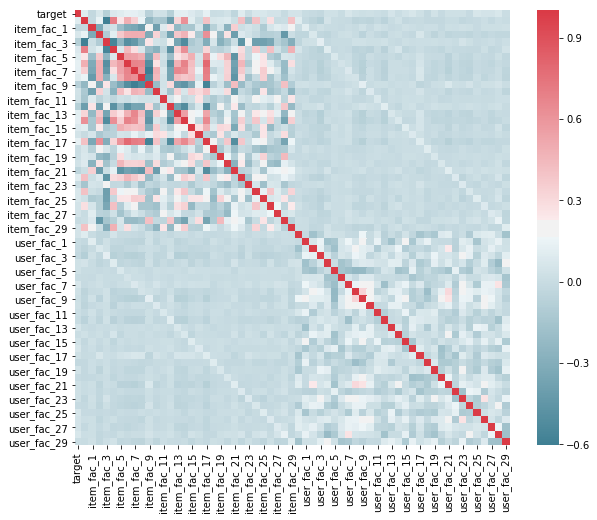

In [15]:
corr = train_df.corr()

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

## Prepare

In [16]:
x = train_df.drop(['target'], axis=1)
y = train_df['target']

# take the last # rows of train_df as valid set where # means number of rows in test_df
x_valid = train_df.drop(['target'], axis=1).tail(test_df.shape[0])
y_valid = train_df['target'].tail(test_df.shape[0])

x_test = test_df.drop(['id'], axis=1)
test_ids = test_df['id']

train_df.head(15)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,item_fac_0,item_fac_1,item_fac_2,item_fac_3,...,user_fac_20,user_fac_21,user_fac_22,user_fac_23,user_fac_24,user_fac_25,user_fac_26,user_fac_27,user_fac_28,user_fac_29
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,0.299137,-0.204471,-0.159251,0.099088,...,0.093982,0.002097,0.040292,0.026109,-0.060797,0.154261,0.161054,-0.037780,-0.189195,0.027857
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,0.002039,0.008335,-0.001113,0.003504,...,-0.008633,0.015745,0.035060,0.001035,0.030397,-0.023668,-0.014755,0.033238,0.057557,-0.061357
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,0.003216,0.010587,-0.001085,0.003361,...,-0.008633,0.015745,0.035060,0.001035,0.030397,-0.023668,-0.014755,0.033238,0.057557,-0.061357
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,0.002039,0.008335,-0.001113,0.003504,...,-0.008633,0.015745,0.035060,0.001035,0.030397,-0.023668,-0.014755,0.033238,0.057557,-0.061357
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,0.186515,-0.286279,-0.190539,0.070333,...,0.093982,0.002097,0.040292,0.026109,-0.060797,0.154261,0.161054,-0.037780,-0.189195,0.027857
5,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3Hg5kugV1S0wzEVLAEfqjIV5UHzb7bCrdBRQlGygLvU=,explore,Explore,online-playlist,1,1.363544,-0.064324,-0.730594,0.345114,...,0.093982,0.002097,0.040292,0.026109,-0.060797,0.154261,0.161054,-0.037780,-0.189195,0.027857
6,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,VkILU0H1h3NMmk9MQrXouNudGk5n8Ls5cqRRuBxeTh4=,my library,Local playlist more,local-playlist,1,1.412263,3.442988,-2.127472,1.158280,...,-0.008633,0.015745,0.035060,0.001035,0.030397,-0.023668,-0.014755,0.033238,0.057557,-0.061357
7,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,bPIvRTzfHxH5LgHrStll+tYwSQNVV8PySgA3M1PfTgc=,explore,Explore,online-playlist,1,0.135857,-0.261926,-0.147452,0.077192,...,0.093982,0.002097,0.040292,0.026109,-0.060797,0.154261,0.161054,-0.037780,-0.189195,0.027857
8,uHqAtShXTRXju5GE8ri3ITsVFepPf8jUoCF7ffNOuqE=,/bU6IRSK+YNlNbaTkxo7bhsb2EDLPrnksdX3ggcZNhI=,my library,Local playlist more,local-library,1,0.047947,0.019333,0.002913,0.004553,...,-0.008504,0.074854,-0.033758,-0.043425,0.052694,0.001308,0.011259,-0.018609,0.040321,0.015023
9,uHqAtShXTRXju5GE8ri3ITsVFepPf8jUoCF7ffNOuqE=,EbI7xoNxI+3QSsiHxL13zBdgHIJOwa3srHd7cDcnJ0g=,my library,Local playlist more,local-library,1,1.532967,-0.019061,0.097441,-0.078094,...,-0.008504,0.074854,-0.033758,-0.043425,0.052694,0.001308,0.011259,-0.018609,0.040321,0.015023


## Core

In [17]:
train_set = lgb.Dataset(x, y)
valid_set = lgb.Dataset(x_valid, y_valid, free_raw_data=False)
watchlist = [valid_set]

params = dict({
    'learning_rate': 0.2,
    'application': 'binary',
    'min_data_in_leaf': 10,
#    'max_depth': 10,
    'num_leaves': 2 ** 7,
    'max_bin': 255,
    'verbosity': 0,
    'metric': 'auc'
})

grid_params = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [8, 10],
}

# best_grid_params = custom_grid_search(params, grid_params, train_set, hold_out_set, num_boost_round=20)
# for key, val in best_grid_params.items():
#     params[key] = best_grid_params[key]

cv_score = custom_cv(params, train_set, valid_set, k_fold=4, num_boost_round=100)
print(cv_score)

model = lgb.train(params, train_set=train_set, valid_sets=watchlist, num_boost_round=100, verbose_eval=5)
y_test = model.predict(x_test)

# When CV, valid_0 means the front 75% training, the last 25% validating
#          valid_1 means the front 75% training, the last "len(test set)" validating
#
# When LGBM running, valid_0 means 100% training, the last "len(test set)" validating.
#
# Use CV valid_0 auc score to predict result!

[5]	valid_0's auc: 0.692277	valid_1's auc: 0.706029
[10]	valid_0's auc: 0.706997	valid_1's auc: 0.722426
[15]	valid_0's auc: 0.716954	valid_1's auc: 0.734102
[20]	valid_0's auc: 0.727351	valid_1's auc: 0.745592
[25]	valid_0's auc: 0.733164	valid_1's auc: 0.752904
[30]	valid_0's auc: 0.737923	valid_1's auc: 0.758856
[35]	valid_0's auc: 0.741433	valid_1's auc: 0.76333
[40]	valid_0's auc: 0.744116	valid_1's auc: 0.766963
[45]	valid_0's auc: 0.745392	valid_1's auc: 0.769091
[50]	valid_0's auc: 0.746899	valid_1's auc: 0.771294
[55]	valid_0's auc: 0.74796	valid_1's auc: 0.773199
[60]	valid_0's auc: 0.749069	valid_1's auc: 0.775112
[65]	valid_0's auc: 0.750521	valid_1's auc: 0.777081
[70]	valid_0's auc: 0.751608	valid_1's auc: 0.778648
[75]	valid_0's auc: 0.752431	valid_1's auc: 0.779978
[80]	valid_0's auc: 0.753156	valid_1's auc: 0.781287
[85]	valid_0's auc: 0.753621	valid_1's auc: 0.782264
[90]	valid_0's auc: 0.754833	valid_1's auc: 0.783876
[95]	valid_0's auc: 0.755847	valid_1's auc: 0.785

## Feature importances

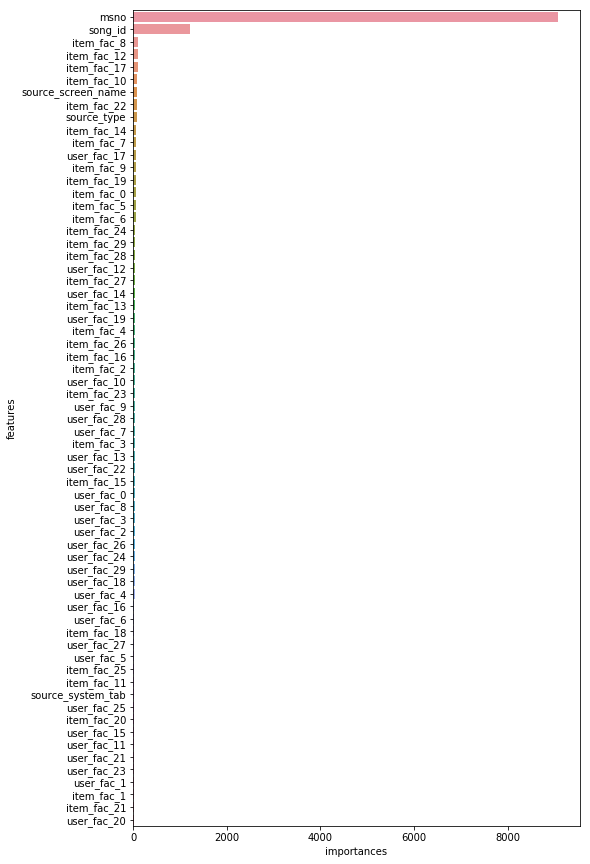

In [18]:
plot_df = pd.DataFrame({'features': train_df.columns[train_df.columns != 'target'],
                        'importances': model.feature_importance()})
plot_df = plot_df.sort_values('importances', ascending=False)

plt.figure(figsize=(8, 15))
sns.barplot(x = plot_df.importances, y = plot_df.features)
plt.show()

## Output

In [19]:
submission_df = pd.DataFrame()
submission_df['id'] = test_ids
submission_df['target'] = y_test
# string file compression reduces file size
submission_df.to_csv('script/submit/submission.csv.gz', compression = 'gzip', index=False, float_format = '%.5f')
submission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556790 entries, 0 to 2556789
Data columns (total 2 columns):
id        int64
target    float64
dtypes: float64(1), int64(1)
memory usage: 39.0 MB
